In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers.legacy import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load in the Dataset

In [2]:
X_train = np.load("/kaggle/input/npyfiles/npy/256_192_train.npy")

In [3]:
y_train = np.load("/kaggle/input/npyfiles/npy/train_labels.npy")

In [4]:
X_val = np.load("/kaggle/input/npyfiles/npy/256_192_val.npy")

In [5]:
y_val = np.load("/kaggle/input/npyfiles/npy/val_labels.npy")

In [6]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [7]:
y_train.shape, y_val.shape

((8111,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load Pretrained Model

In [10]:
pre_trained_model = InceptionResNetV2(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

219055592/219055592 [==============================] - 1s 0us/step


In [11]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed_5b
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
conv2d_12
conv2d_14
conv2d_17
batch_normalization_12
batch_normalization_14
batch_normalization_17
activation_12
activation_14
activation_17
block35_1_mixed
block35_1_conv
custom_scale_layer
block35_1_ac
conv2d_21
batch_normalization_21
activation_21
conv2d_19
conv2

In [12]:
last_layer = pre_trained_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 1536)


## Define the Model

In [13]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

## Training

### Feature Extraction

In [15]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [16]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/tmp/ipykernel_26/3971016608.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/3
126/126 [==============================] - 126s 821ms/step - loss: 1.5130 - accuracy: 0.5962 - val_loss: 4.0939 - val_accuracy: 0.6920
Epoch 2/3
126/126 [==============================] - 97s 762ms/step - loss: 1.0910 - accuracy: 0.6631 - val_loss: 1.0135 - val_accuracy: 0.6830
Epoch 3/3
126/126 [==============================] - 97s 763ms/step - loss: 1.0232 - accuracy: 0.6724 - val_loss: 0.9662 - val_accuracy: 0.6964


### Fine Tuning

In [17]:
pre_trained_model.layers[617].name

'mixed_7a'

In [18]:
for layer in pre_trained_model.layers[618:]:
    layer.trainable = True

In [19]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

In [22]:
batch_size = 64
epochs = 25
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/tmp/ipykernel_26/1600363926.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/25
126/126 [==============================] - 122s 832ms/step - loss: 0.8809 - acc: 0.7045 - val_loss: 0.8075 - val_acc: 0.7143 - lr: 1.0000e-04
Epoch 2/25
126/126 [==============================] - 102s 801ms/step - loss: 0.7400 - acc: 0.7349 - val_loss: 0.7696 - val_acc: 0.7098 - lr: 1.0000e-04
Epoch 3/25
126/126 [==============================] - 101s 799ms/step - loss: 0.6413 - acc: 0.7695 - val_loss: 0.7121 - val_acc: 0.7567 - lr: 1.0000e-04
Epoch 4/25
126/126 [==============================] - 101s 801ms/step - loss: 0.6025 - acc: 0.7843 - val_loss: 0.6927 - val_acc: 0.7500 - lr: 1.0000e-04
Epoch 5/25
126/126 [==============================] - 101s 799ms/step - loss: 0.5467 - acc: 0.8066 - val_loss: 0.6021 - val_acc: 0.7946 - lr: 1.0000e-04
Epoch 6/25
126/126 [==============================] - 101s 800ms/step - loss: 0.5081 - acc: 0.8131 - val_loss: 0.6139 - val_acc: 0.7768 - lr: 1.0000e-04
Epoch 7/25
126/126 [==============================] - 101s 800ms/step - loss: 0.47

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=1)

In [24]:
 model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                     epochs = 5, validation_data = val_datagen.flow(X_val, y_val),
                     verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                     validation_steps=(X_val.shape[0] // batch_size),
                     callbacks=[learning_rate_reduction])

/tmp/ipykernel_26/1915657347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/5
126/126 [==============================] - 101s 799ms/step - loss: 0.1567 - acc: 0.9435 - val_loss: 0.6937 - val_acc: 0.8304 - lr: 1.2500e-05
Epoch 2/5
126/126 [==============================] - 101s 799ms/step - loss: 0.1408 - acc: 0.9484 - val_loss: 0.6023 - val_acc: 0.8504 - lr: 1.2500e-05
Epoch 3/5
126/126 [==============================] - 101s 799ms/step - loss: 0.1406 - acc: 0.9497 - val_loss: 0.7148 - val_acc: 0.8304 - lr: 1.2500e-05
Epoch 4/5
126/126 [==============================] - ETA: 0s - loss: 0.1382 - acc: 0.9532
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
126/126 [==============================] - 101s 799ms/step - loss: 0.1382 - acc: 0.9532 - val_loss: 0.6327 - val_acc: 0.8504 - lr: 1.2500e-05
Epoch 5/5
126/126 [==============================] - 101s 797ms/step - loss: 0.1425 - acc: 0.9492 - val_loss: 0.5667 - val_acc: 0.8594 - lr: 6.2500e-06


In [25]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 6s 194ms/step - loss: 0.6282 - acc: 0.8437
Validation: accuracy = 0.843681  ;  loss_v = 0.628217


## Testing

In [26]:
X_test = np.load("/kaggle/input/npyfiles/npy/256_192_test.npy")

In [27]:
y_test = np.load("/kaggle/input/npyfiles/npy/test_labels.npy")
y_test = to_categorical(y_test)

In [28]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 6s 194ms/step - loss: 0.6347 - acc: 0.8543
Test: accuracy = 0.854291  ;  loss = 0.634651


In [29]:
model.save("InceptionResNet.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training and validation loss')

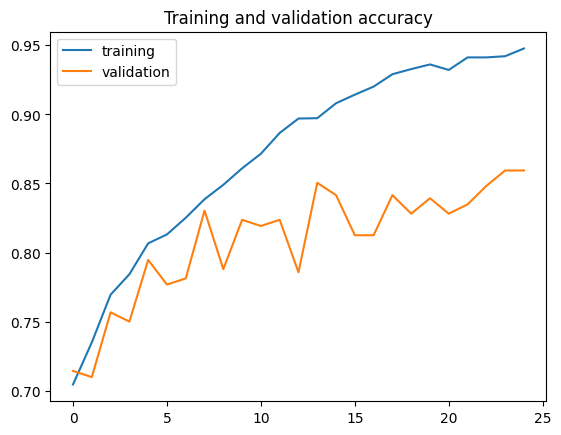

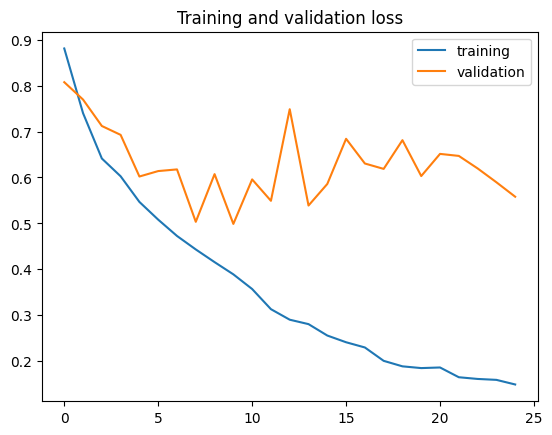

In [30]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')